In [ ]:
import os
import random
import gc
import time
import re
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, precision_recall_curve, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV
import warnings
import matplotlib.pyplot as plt
from collections import Counter
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive

# Montez votre Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chemin complet vers votre fichier
file_path = '/content/drive/MyDrive/OC-Projet-7/out_put/data.csv'
file_path2 = '/content/drive/MyDrive/OC-Projet-7/out_put/data_test.csv'
# Lisez le fichier avec pandas
import pandas as pd
data = pd.read_csv(file_path)
data_test = pd.read_csv(file_path2)

In [ ]:
# Export pour réutilisation
data.to_csv("/content/drive/MyDrive/OC-Projet-7/out_put/data.csv")
data_test.to_csv("/content/drive/MyDrive/OC-Projet-7/out_put/data_test.csv")

In [ ]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print("Label 1 dans le jeu d'entrainement: {}".format(sum(y_train==1)))
print("Label 0 dans le jeu d'entrainement: {}".format(sum(y_train==0)))

Label 1 dans le jeu d'entrainement: 18569
Label 0 dans le jeu d'entrainement: 212061


In [ ]:
# Sous échntillonage pour équilibrer le jeu d'entrainement
from imblearn.under_sampling import RandomUnderSampler
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

In [ ]:
print("Label 1 dans le jeu retravaillé: {}".format(sum(y_ru==1)))
print("Label 0 dans le jeu retravaillé: {}".format(sum(y_ru==0)))

Label 1 dans le jeu retravaillé: 18569
Label 0 dans le jeu retravaillé: 18569


In [ ]:
def custom_cost(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    cost = (10 * fn + fp) / len(y_true)  # Faux négatif coûte 10 fois plus cher que le faux positif
    return cost

In [ ]:
# Créer une fonction scorer avec make_scorer
custom_scorer = make_scorer(custom_cost, greater_is_better=False, needs_threshold=True)

In [ ]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format=".0f")
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [ ]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=True):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold AUC = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [ ]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict values
    y_pred = model.predict(x_test)
    y_pred_train =model.predict(X_ru)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Draw roc curve
    auc_score_test = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    clf_report_train = pd.DataFrame(classification_report(y_ru, y_pred_train, output_dict=True)).transpose()
    display(clf_report)


    return auc_score_test, clf_report, clf_report_train

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2Yr29VM4O75CyEtIinQLFUnZU0l_3oLvE4D4m81BPzRv1tHtB"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://67ee-35-192-188-199.ngrok-free.app


In [ ]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None, auc_score_train=None, f1_score_train=None, acc_score_train=None,
               train_class_0=None, train_class_1=None, fit_duration=None, predict_duration=None):

    # Track params and metrics
    with mlflow.start_run(run_name="credit_scoring"):
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)
        mlflow.log_metric("AUC train", auc_score_train)
        mlflow.log_metric("F1 train", f1_score_train)
        mlflow.log_metric("Accuracy train", acc_score_train)
        mlflow.log_metric("fit_duration", fit_duration)
        mlflow.log_metric("predict_duration", predict_duration)

    mlflow.end_run()

In [ ]:
import re

X_ru.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_ru.columns]
X_test.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X_ru.columns]

In [ ]:
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.arange(0.01, 1.0, 0.001)
    best_custom_score = 100
    optimal_threshold = 0  # Valeur par défaut

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        custom_score=custom_cost(y_test, y_pred)

        if custom_score < best_custom_score:
            best_custom_score = custom_score
            optimal_threshold = threshold

    return optimal_threshold

In [ ]:
from sklearn.dummy import DummyClassifier
#Moyenne
cls=DummyClassifier(strategy='most_frequent')
cls.fit(X_ru, y_ru)
y_pred_dum = cls.predict(X_test)

In [ ]:
custom_cost(y_test, y_pred_dum)

0.8137674467005737

In [ ]:
log_reg=LogisticRegression()
log_reg.fit(X_ru, y_ru)
y_pred_base = log_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
custom_cost(y_test, y_pred_base)

0.8712098547029671

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 7),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'colsample_bynode': [0.8, 1.0]
}

random_search = RandomizedSearchCV(LGBMClassifier(verbose=-1), param_distributions=param_dist, n_iter=10, scoring=custom_scorer, cv=5, n_jobs=-1)
random_search.fit(X_ru, y_ru)

print(random_search.best_params_)
print(random_search.best_score_)

{'colsample_bylevel': 0.8, 'colsample_bynode': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 162, 'subsample': 1.0}
-1.5851942283097393


In [ ]:
%%time
grid_search = GridSearchCV(XGBClassifier(), {'learning_rate': [0.1, 0.01], 'n_estimators': [100, 500], 'max_depth': [3, 5], 'colsample_bytree': [0.8, 1.0], 'subsample': [0.8, 1.0]}, scoring=custom_scorer, cv=5, n_jobs=-1)
grid_search.fit(X_ru, y_ru)

print(grid_search.best_params_)
print(grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
-1.5860031827286938
CPU times: user 2min 21s, sys: 2.81 s, total: 2min 24s
Wall time: 19min 19s


In [ ]:
best_lgbm=LGBMClassifier(verbose=-1, learning_rate=0.1, n_estimators=162, max_depth=3, subsample=0.8, colsample_bytree=1.0, colsample_bylevel=0.8, colsample_bynode=0.8)
start_time_fit = time.time()
best_lgbm.fit(X_ru, y_ru)
end_time_fit = time.time()
start_time_predict = time.time()
y_probs_lgb = best_lgbm.predict_proba(X_test)[:, 1]
end_time_predict = time.time()
best_thresholds_lgbm = find_optimal_threshold(y_test, y_probs_lgb)

In [ ]:
best_thresholds_lgbm

0.5249999999999996

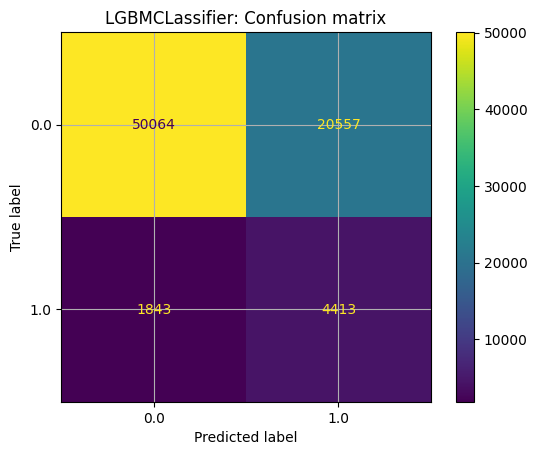

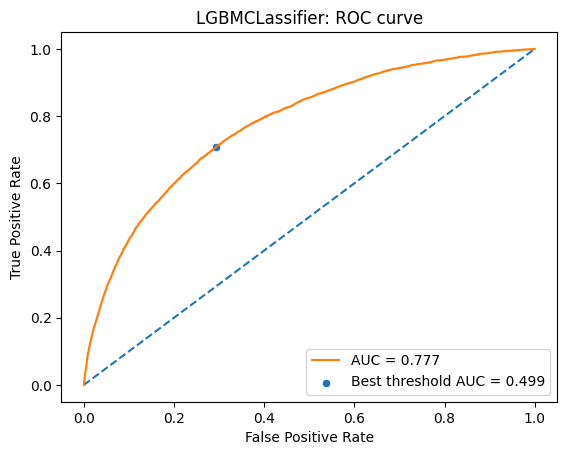

,precision,recall,f1-score,support
0.0,0.964494,0.708911,0.817185,70621.000000
1.0,0.176732,0.705403,0.282649,6256.000000
accuracy,0.708625,0.708625,0.708625,0.708625
macro avg,0.570613,0.707157,0.549917,76877.000000
weighted avg,0.900389,0.708625,0.773686,76877.000000


In [ ]:
cost=custom_cost(y_test, y_probs_lgb, threshold=best_thresholds_lgbm)
auc_score, clf_report, clf_report_train = compute_classification_results(best_lgbm, "LGBMCLassifier", X_test, y_test)
y_pred_proba_train = best_lgbm.predict_proba(X_ru)[:,1]
auc_score_train = roc_auc_score(y_ru, y_pred_proba_train)

In [ ]:
log_mlflow(best_lgbm, "LGBMCLassifier",
           custom_score=cost,
           auc_score=auc_score,
           f1_score=clf_report.loc['weighted avg', 'f1-score'],
           acc_score=clf_report.loc['accuracy', 'precision'],
           auc_score_train=auc_score_train,
           f1_score_train=clf_report_train.loc['weighted avg', 'f1-score'],
           acc_score_train=clf_report_train.loc['accuracy', 'precision'],
           train_class_0=Counter(y_ru)[0],
           train_class_1=Counter(y_ru)[1],
           fit_duration=end_time_fit-start_time_fit,
           predict_duration=end_time_predict-start_time_predict)

In [ ]:
best_xgb=XGBClassifier(colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 3, n_estimators= 500, subsample= 1.0)
start_time_fit = time.time()
best_xgb.fit(X_ru, y_ru)
end_time_fit = time.time()
start_time_predict = time.time()
y_probs_xgb = best_xgb.predict_proba(X_test)[:, 1]
end_time_predict = time.time()
best_thresholds_xgb = find_optimal_threshold(y_test, y_probs_xgb)

In [ ]:
best_thresholds_xgb

0.5639999999999995

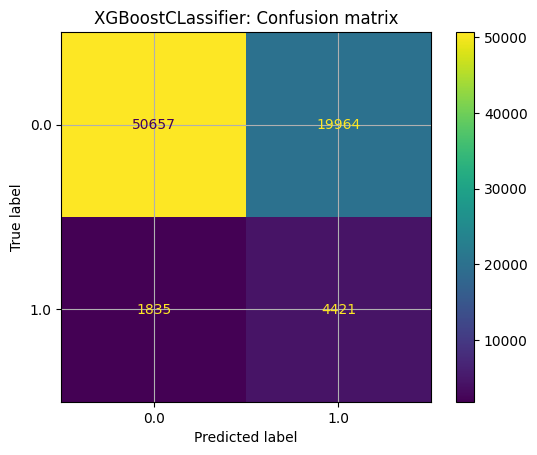

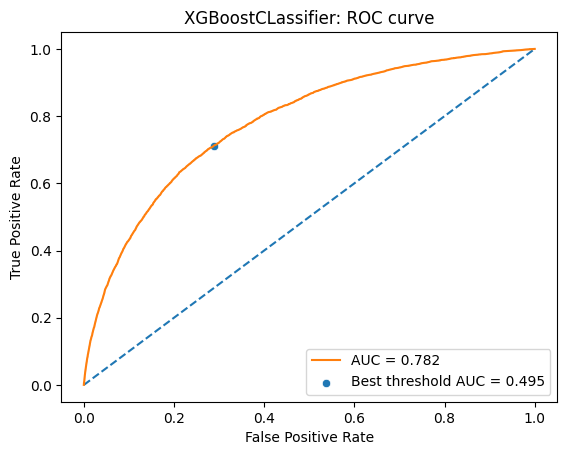

,precision,recall,f1-score,support
0.0,0.965042,0.717308,0.822935,70621.000000
1.0,0.181300,0.706682,0.288568,6256.000000
accuracy,0.716443,0.716443,0.716443,0.716443
macro avg,0.573171,0.711995,0.555751,76877.000000
weighted avg,0.901264,0.716443,0.779450,76877.000000


In [ ]:
cost=custom_cost(y_test, y_probs_xgb, threshold=best_thresholds_xgb)
auc_score, clf_report, clf_report_train = compute_classification_results(best_xgb, "XGBoostCLassifier", X_test, y_test)
y_pred_proba_train = best_xgb.predict_proba(X_ru)[:,1]
auc_score_train = roc_auc_score(y_ru, y_pred_proba_train)

In [ ]:
log_mlflow(best_xgb, "XGBoostCLassifier",
           custom_score=cost,
           auc_score=auc_score,
           f1_score=clf_report.loc['weighted avg', 'f1-score'],
           acc_score=clf_report.loc['accuracy', 'precision'],
           auc_score_train=auc_score_train,
           f1_score_train=clf_report_train.loc['weighted avg', 'f1-score'],
           acc_score_train=clf_report_train.loc['accuracy', 'precision'],
           train_class_0=Counter(y_ru)[0],
           train_class_1=Counter(y_ru)[1],
           fit_duration=end_time_fit-start_time_fit,
           predict_duration=end_time_predict-start_time_predict)

In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
shap.initjs()

In [ ]:
# compute SHAP values
explainer= shap.TreeExplainer(best_lgbm)
shap_values = explainer(X_test)

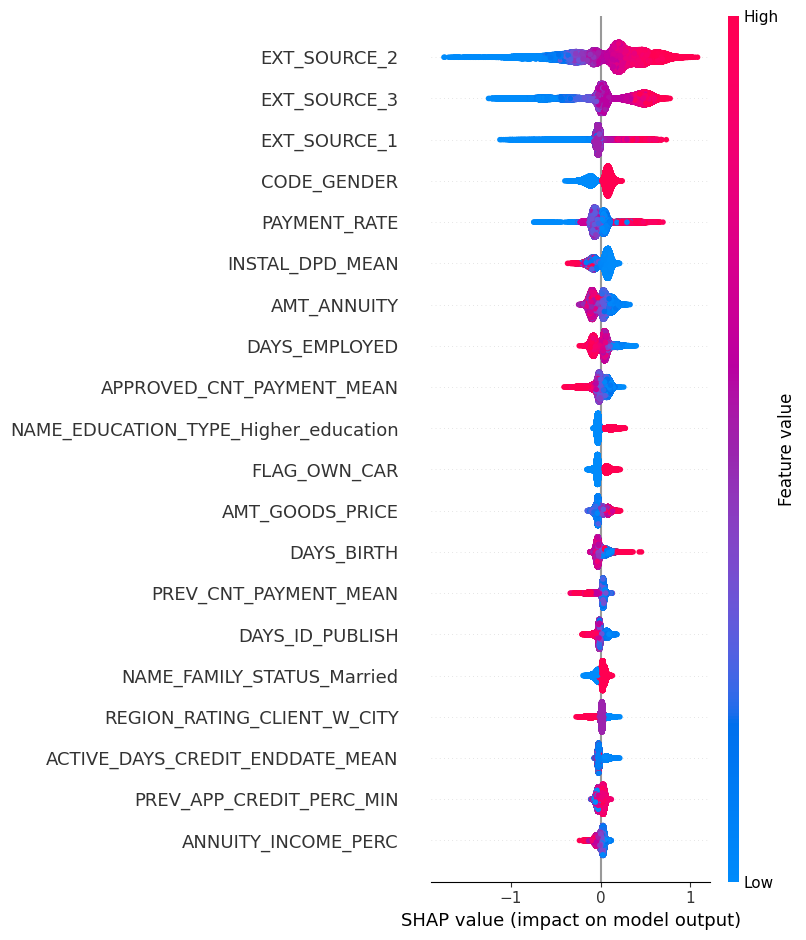

In [ ]:
shap.summary_plot(shap_values.values[:,:,0], X_test)

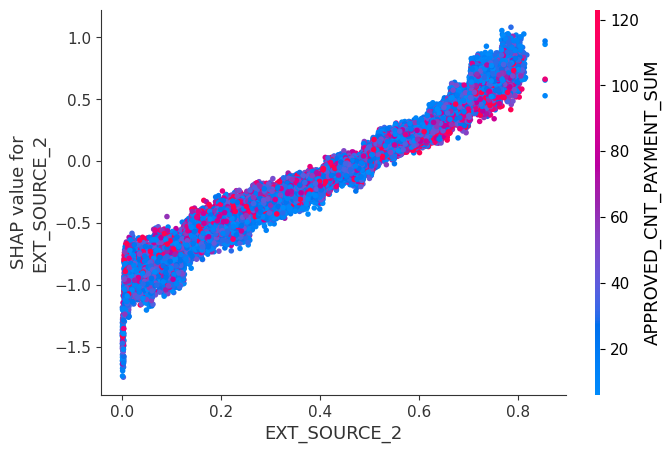

In [ ]:
shap.dependence_plot("EXT_SOURCE_2", shap_values.values[:,:,0], X_test)

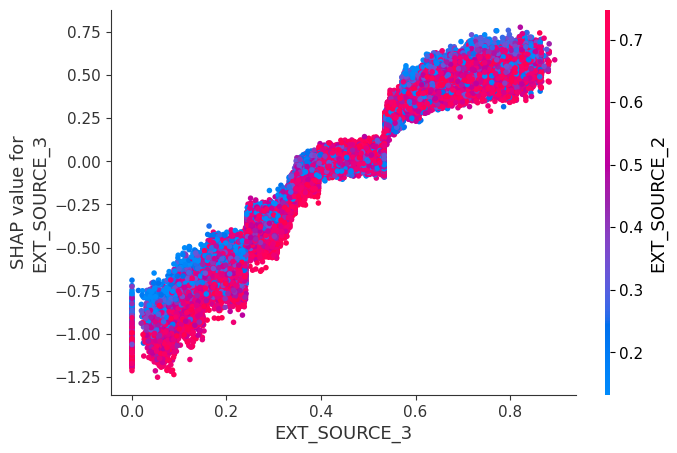

In [ ]:
shap.dependence_plot("EXT_SOURCE_3", shap_values.values[:,:,0], X_test)

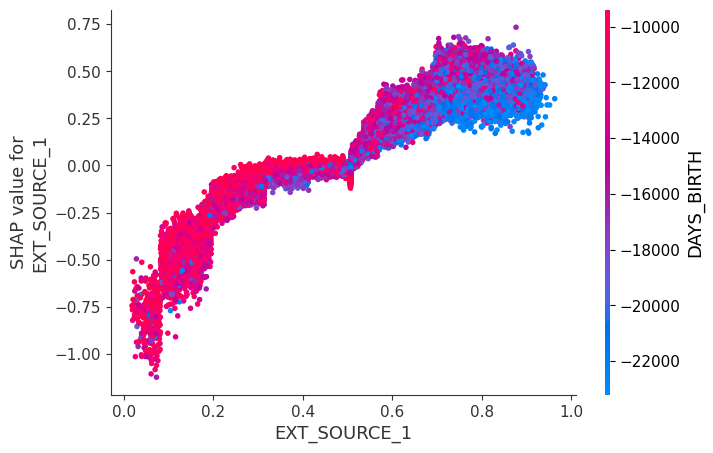

In [ ]:
shap.dependence_plot("EXT_SOURCE_1", shap_values.values[:,:,0], X_test)

# **Interprétation locale**

Client numero :  13604


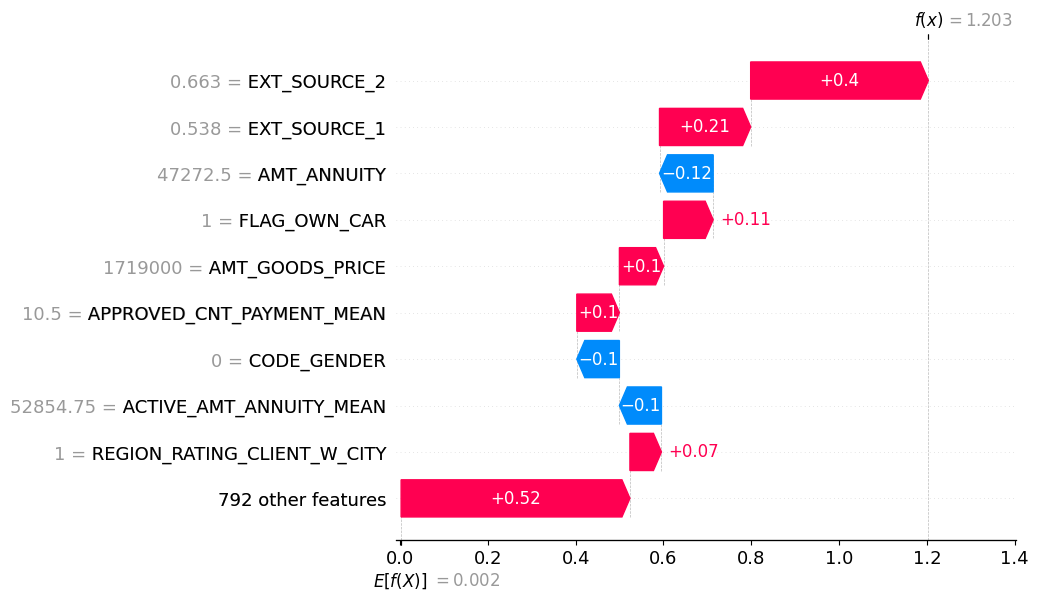

In [ ]:
idx = random.randint(1, len(X_test))
print("Client numero : ", idx)
exp = shap.Explanation(shap_values.values[:,:,0], shap_values.base_values[:,0], data=X_test.values, feature_names=X_test.columns)
shap.plots.waterfall(exp[idx])

Client numero :  75396


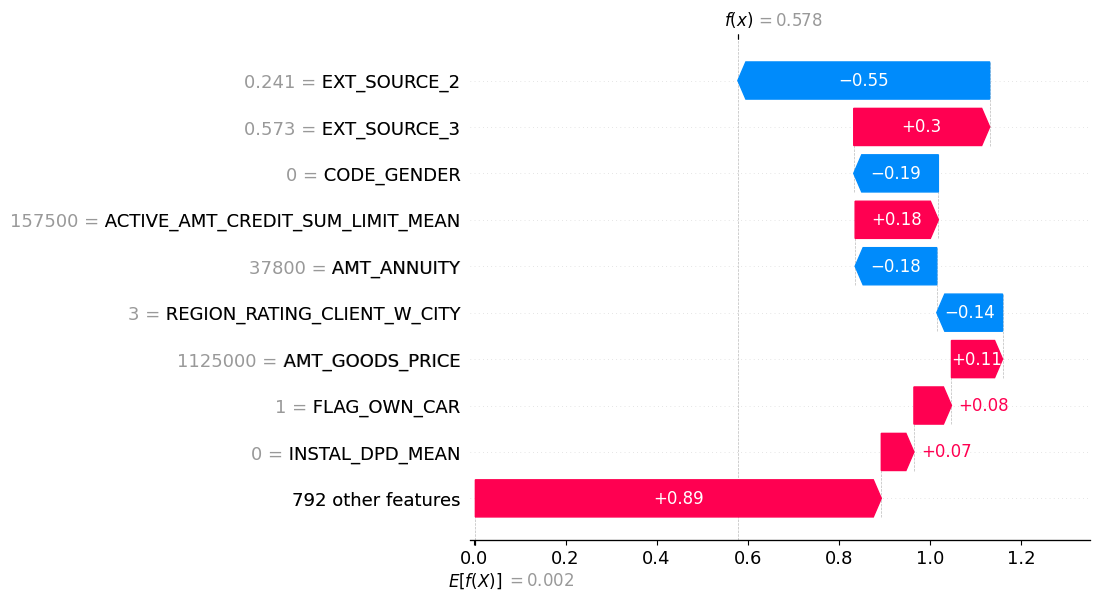

In [ ]:
idx = random.randint(1, len(X_test))
print("Client numero : ", idx)
exp = shap.Explanation(shap_values.values[:,:,0], shap_values.base_values[:,0], data=X_test.values, feature_names=X_test.columns)
shap.plots.waterfall(exp[idx])

#Sauvegarde des fichiers pour réutilisation dans le dashboard

In [ ]:
# Calcul de la probabilité que le client ne fasse pas défaut (valeur=0) et ajout au dataset pour export
score = best_lgbm.predict_proba(data.drop('TARGET', axis=1))[:,0]
data.loc[:, 'score']=score

In [ ]:
# Création d'un échantillon pour utilisation dans le dashboard
data_sample=data.sample(n=10000)
data_sample.to_csv("/content/drive/MyDrive/OC-Projet-7/out_put/data_sample.csv")

In [ ]:
data_p=data_sample.drop(['TARGET', 'score'], axis=1)

In [ ]:
# Calculer les shap values des data pour intégration dans le dashboard
sv= explainer(data_p)
exp = shap.Explanation(sv.values[:,:,0], sv.base_values[:,0], data=data_p.values, feature_names=data_p.columns)

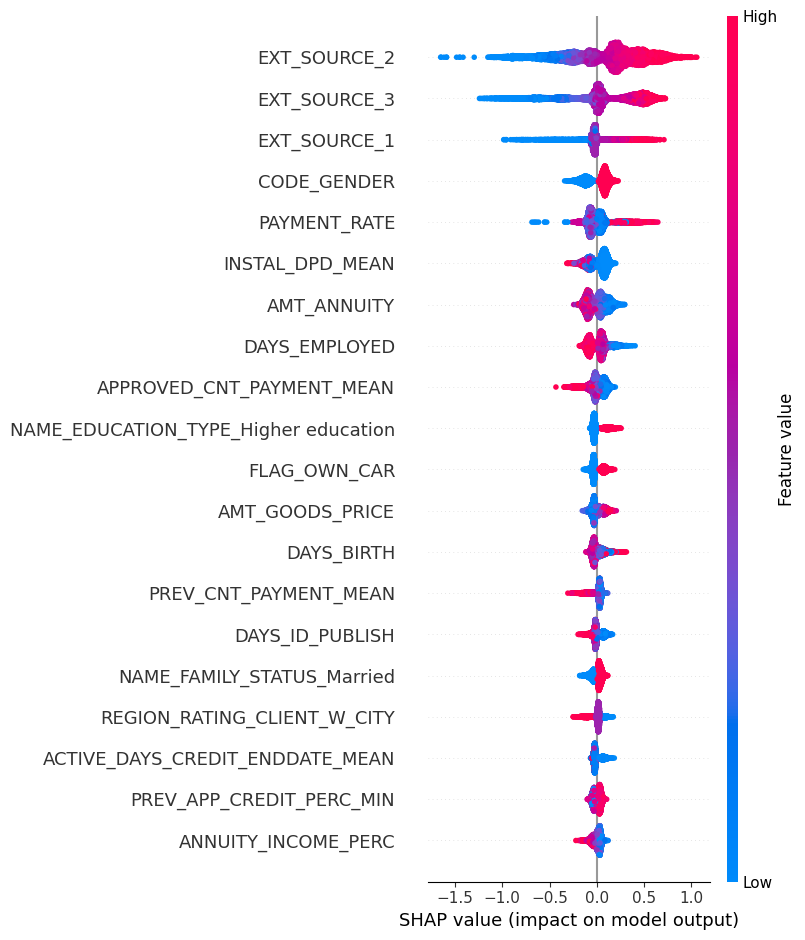

In [ ]:
# sauvegarde de l'image de la feature importance globale pour les data test
fig=shap.summary_plot(sv.values[:,:,0], data_p, show=False)
plt.savefig("/content/drive/MyDrive/OC-Projet-7/Graphs/sum_plot.png")

In [ ]:
# Export du fichier pickle avec le modèle utilisé
import pickle
pickle_out = open("/content/drive/MyDrive/OC-Projet-7/lgbm.pkl","wb")
pickle.dump(best_lgbm, pickle_out)
pickle_out.close()

In [ ]:
# Export des shap explanation locales
pickle_out = open("/content/drive/MyDrive/OC-Projet-7/exp.pkl","wb")
pickle.dump(exp, pickle_out)
pickle_out.close()

In [ ]:
# Export du threshold de prédiction
pickle_out = open("/content/drive/MyDrive/OC-Projet-7/threshold.pkl","wb")
pickle.dump(best_thresholds_lgbm, pickle_out)
pickle_out.close()